In [2]:
%%capture

#todo pick model name and then run the corresponding notebooks
model_name = '01d_ResNet20_CIFAR-10'
#model_name = 'LeNet-MNIST'
%run '03_TFLu-on-MCU.ipynb'

# Debugging the UART Interface

#### Code for debugging the serial connection

In [22]:
import serial
import time
 # write_timeout = 10
port = serial.Serial(port = '/dev/tty.usbmodem1453103', baudrate=1000000, timeout=5,
                     stopbits=serial.STOPBITS_ONE, bytesize=8)


In [ ]:
port.write(bytes(bytearray(test_image[:32])))

In [ ]:
test_image = np.array(x_test_normalized[32].flatten(), np.float32)
print(test_image.shape)


for i in range(1024//32):
    port.write(bytes(bytearray(test_image[:32])))
    time.sleep(1)

# for b in test_image:
#     port.write(bytes(bytearray(b)))
#     #time.sleep(0.0001)

In [82]:
x_test_normalized[3152].shape

(32, 32, 1)

In [15]:
send_image(port, x_test_normalized[image_no])

In [24]:
print(port.read_all().decode("utf-8"))
#print(port.read_all())

Arena size is too small for activation buffers. Needed 196608 but only 155064 was available.
AllocateTensors() failed



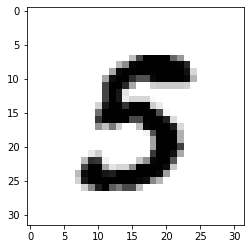

In [266]:
# pick a random image
image_no = np.random.randint(10000)

# use a single example image from the normalized training set
#result = tf_model.predict(np.array( [ x_test_normalized[image_no] ] ))


plt.imshow(x_test_normalized[image_no].squeeze(), cmap=plt.cm.gray_r)
plt.show()

In [ ]:
mcu_prediction, benchmark_result = read_results(port)
print(mcu_prediction)
print(benchmark_result)

In [31]:
print(port.read_all().decode("utf-8"))
#print(port.read_all())

In [ ]:
float.fromhex('\t0x1.fep-1')

In [ ]:
arr = np.array(b' \x00\x1e\xe0', np.float32)

In [ ]:
import struct

In [ ]:
struct.unpack('>f', b'\x20\x00\x1e\xe0')

In [ ]:
read = port.read_all().decode("utf-8")

In [ ]:
read

In [ ]:
#print(port.readline())
assert(port.readline())

In [254]:
port.close()

In [ ]:
port.flushOutput()
port.flushInput()

## Verification and Inference on the MCU

#### Helpers

In [3]:
def set_port(port, baudrate):
    port = serial.Serial(port = port, baudrate=baudrate, timeout=60, write_timeout=None,
                         stopbits=serial.STOPBITS_ONE, bytesize=8)
    
    return port

In [4]:
def send_image(port, image):
    image = np.array(image.flatten(), np.float32)

    if platform == "darwin":
        for b in image:
            port.write(bytes(bytearray(b)))
            time.sleep(0.0005)
    else:
        port.write(bytes(bytearray(image)))

In [5]:
def read_results(port):
    try:
        output = port.read_until(bytes("_end_report_\n\n".encode('utf-8')))
    except serial.SerialTimeoutException:
        print("Read timeout ...")
        return -1, -1
    except err:
        print("Unknown error:", err)
        return -1, -1

    
    output = output.decode('utf-8')
    prediction = np.empty((0))
    benchmark_result = -1
    layers_benchmarks = {}

    lines = iter(output.splitlines())
    
    for line in lines:
        if "Number of inferences" in line:
            number_of_inferences = int(next(lines))
       
        elif "Duration of inferences in" in line:
            benchmark_result = int(next(lines))
            benchmark_result = benchmark_result / number_of_inferences
    
        elif "Class" in line:
            prediction = np.append(prediction, (float.fromhex(next(lines))))
            
        elif "Layer" in line:
            layer_type = str(line[8:]) # skip 'Layer_'
            layers_benchmarks[layer_type] = int(next(lines))
            
        elif not line or "_end_report_" in line or "_start_report_" in line:
            # empty line - skip
            next(lines)

        else:
            print("Unknown serial input:\n", line, next(lines))
    
    # when we didn't read any benchmark results
    # replace the return value with the benchmarking results
    if benchmark_result == -1:
        benchmark_result = layers_benchmarks
    
    return prediction, benchmark_result

#### Sent images to MCU and log predictions

This function sends the whole normalized testset to the MCU, waits for the predictions and logs them.

In [194]:
def verify_accuracy_on_mcu(port, test=False):

    mcu_predictions = np.empty((0, 10), np.float32)
    benchmark_results = np.empty((0))

    # [[0.         0.         0.99609375 0.         0.         0.
    #  0.         0.         0.         0.        ]]
    if test:
        testset = x_test_normalized[:10]
    else:
        testset = x_test_normalized
    for test_image in testset:
        send_image(port, test_image)
        mcu_prediction, benchmark_result = read_results(port)
        mcu_predictions = np.append(mcu_predictions, [mcu_prediction], axis=0)
        benchmark_results = np.append(benchmark_results, benchmark_result)

    return mcu_predictions, benchmark_results

In [61]:

port = set_port('/dev/tty.usbmodem142103', 1000000)
mcu_predictions, benchmark_results = verify_accuracy_on_mcu(port, test=True)

print(mcu_predictions, benchmark_results)
print(y_test[:10])

[[0.         0.         0.         0.         0.         0.
  0.         0.99609375 0.         0.        ]
 [0.         0.         0.99609375 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.99609375 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99609375 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.99609375 0.
  0.         0.         0.         0.        ]
 [0.         0.99609375 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.99609375 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.99609375]
 [0.         0.         0.         0.         0.         0.96875
  0.015625   0.         0.01171875 0.        ]
 [0.         0.         0.      

### Compare accuracies

In [ ]:
accurate_count = 0

for index in range(len(mcu_predictions)):
    if np.argmax(mcu_predictions[index]) == np.argmax(y_test[index]):
        accurate_count += 1

mcu_accuracy = accurate_count * 1.0 / len(mcu_predictions)

print("TF Lite Model on MCU Accuracy:\t", mcu_accuracy)
print("TF Lite Model Accuracy:\t\t", tfl_model_accuracy)
print('Original model accuracy:\t', tf_model_accuracy)
print()
loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction='sum_over_batch_size')
mcu_crossentropy_loss = loss_fn(y_test[:10], mcu_predictions).numpy()

print("TF Lite Model on MCU cross entropy loss:\t", mcu_crossentropy_loss)
print("TF Lite Model cross entropy loss:\t\t", tfl_crossentropy_loss)
print('Original model cross entropy loss:\t\t', tf_model_loss)